In [35]:
import pyiron
import numpy as np
import matplotlib.pylab as plt
import scipy.optimize

In [101]:
potential = 'FeH-NNIP'

In [102]:
pr = pyiron.Project('diff')

In [103]:
bulk = pr.create.structure.bulk('Fe', cubic=True)
cell = bulk.get_cell()
a = np.linalg.norm(cell[0])
supercell = bulk.repeat([20,20,20])

In [104]:
# generate H coordinate's parameters
def generate_unique_random_rows(low, high, size):
    rows = set()
    result = []

    while len(result) < size[0]:
        row = tuple(np.random.randint(low, high, size=size[1]))
        if row not in rows:
            rows.add(row)
            result.append(row)
    
    return np.array(result)

# Parameters
low = 1
high = 20
size = [160, 3]

# Generate the array
unique_random_array = generate_unique_random_rows(low, high, size)

# Verify the shape of the array
print(unique_random_array.shape)  # Should print: (160, 3)

(160, 3)


In [74]:
k = unique_random_array
rand_H = supercell.copy()
# num = len(rand_H)

for i in range(160):

    x = a/np.random.uniform(1.59, 2.79) + k[i][0]*a
    y = a/2/np.random.uniform(3.49, 10000) + k[i][1]*a
    z = a/np.random.uniform(1.59, 2.79) + k[i][2]*a
    
    H = pr.create.structure.atoms('H', positions=[(x, y, z)], cell = rand_H.get_cell())
    rand_H += H


In [105]:
k = unique_random_array
rand_H = supercell.copy()
# num = len(rand_H)

for i in range(160):

    x = a/np.random.uniform(1.6, 2.8) + k[i][0]*a
    y = a/2/np.random.uniform(3.5, 10000) + k[i][1]*a
    z = a/np.random.uniform(1.6, 2.8) + k[i][2]*a
    
    H = pr.create.structure.atoms('H', positions=[(x, y, z)], cell = rand_H.get_cell())
    rand_H += H


In [106]:
rand_H.plot3d()

NGLWidget()

In [107]:
job_NPT = pr.create.job.Lammps('NPT', delete_existing_job=True)
job_NPT.structure = rand_H
job_NPT.potential = potential
job_NPT.calc_md(temperature=300, pressure=0.0, n_ionic_steps=2500, time_step=0.5)
job_NPT.run(delete_existing_job=True)

The job NPT was saved and received the ID: 10585


/home/gu.huang/miniconda3/envs/pyiron/lib/python3.12/site-packages/pyiron_atomistics/lammps/interactive.py:435: SyntaxWarning: invalid escape sequence '\A'
  """
/home/gu.huang/miniconda3/envs/pyiron/lib/python3.12/site-packages/pyiron_atomistics/lammps/base.py:119: SyntaxWarning: invalid escape sequence '\A'
  """
/home/gu.huang/miniconda3/envs/pyiron/lib/python3.12/site-packages/pyiron_atomistics/lammps/output.py:178: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+",
/home/gu.huang/miniconda3/envs/pyiron/lib/python3.12/site-packages/pyiron_atomistics/lammps/output.py:330: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(StringIO(thermo_lines), sep="\s+", engine="c")


ValueError: could not convert string to float: '###'

In [ ]:
job_NPT.animate_structures()

In [80]:
structure = job_NPT.get_structure(-1)
job_NVT = pr.create.job.Lammps('NVT', delete_existing_job=True)
job_NVT.structure = structure
job_NVT.potential = potential
job_NVT.calc_md(temperature=300, n_ionic_steps=50000, time_step=0.5)
job_NVT.run(delete_existing_job=True)

The job NVT was saved and received the ID: 10584


In [88]:
job_NVT.animate_structures()

NGLWidget(max_frame=500)

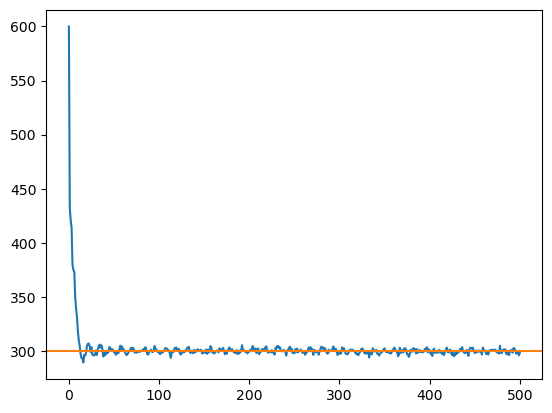

In [89]:
plt.plot(job_NVT.output.temperature)
plt.axhline(y=300, c="tab:orange")

In [90]:
job_NVT.output.total_displacements[11:, 16000:, :].shape

(490, 160, 3)

In [91]:
dxyz  = job_NVT.output.total_displacements[11:, 16000:, :] - job_NVT.output.total_displacements[11:, 16000:, :][0]
print(dxyz.shape)
# Calculate the Euclidean norm along the last axis (axis=-1)
dr = np.linalg.norm(dxyz, axis=-1)
dr = dr[..., np.newaxis]

dR = dr**2
print(dR.shape)  

msd = dR.mean(axis=(1))/160
print(msd.shape)

(490, 160, 3)
(490, 160, 1)
(490, 1)


In [92]:
t = job_NVT.output.steps *1E-15 # timestep is fs
msd *= 1E-20 # lengths scale is Å, here it is squared

In [93]:
msd = msd.reshape(len(msd))
msd.shape

(490,)

D_H = 7.180e-12 m**2/s


/tmp/ipykernel_2051448/4024798041.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("D_H = %.3e m**2/s" %(a/2/3))


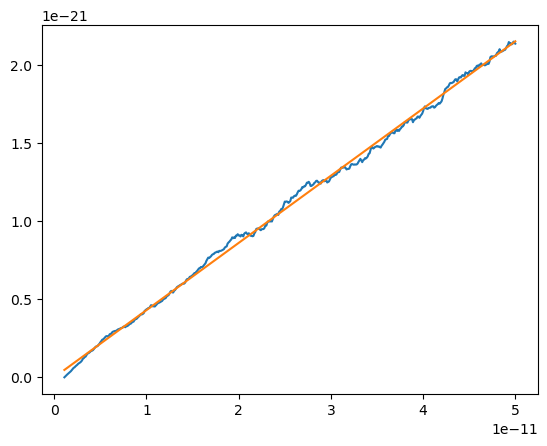

In [94]:
fitfunc = lambda t, a: a*t 
res = scipy.optimize.curve_fit(fitfunc, t[11:], msd)
a= res[0]
plt.plot(t[11:], msd)
plt.plot(t[11:], fitfunc(t[11:], a))
print("D_H = %.3e m**2/s" %(a/2/3))

different T:
400
500
600
800

In [95]:
dR  = job_NVT.output.total_displacements[11:, :16000, :] - job_NVT.output.total_displacements[11:, :16000, :][0]
dR  = dR**2
msd = dR.mean(axis=(1))/160

In [96]:
t = job_NVT.output.steps *1E-15 # timestep is fs
msd *= 1E-20 # lengths scale is Å, here it is squared

In [97]:
msd[:, 0].shape

(490,)

D_1 = 1.037e-14 m**2/s


/tmp/ipykernel_2051448/664569686.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("D_1 = %.3e m**2/s" %(a/2))


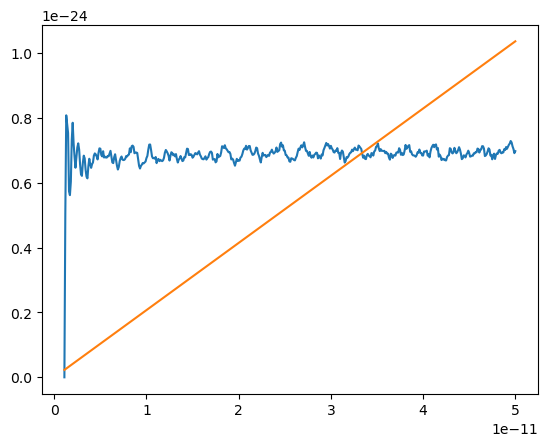

In [98]:
fitfunc = lambda t, a: a*t 
res = scipy.optimize.curve_fit(fitfunc, t[11:], msd[:, 0])
a = res[0]
plt.plot(t[11:], msd[:, 0])
plt.plot(t[11:], fitfunc(t[11:], a))
print("D_1 = %.3e m**2/s" %(a/2))

D_2 = 1.037e-14 m**2/s


/tmp/ipykernel_2051448/3410045304.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("D_2 = %.3e m**2/s" %(a/2))


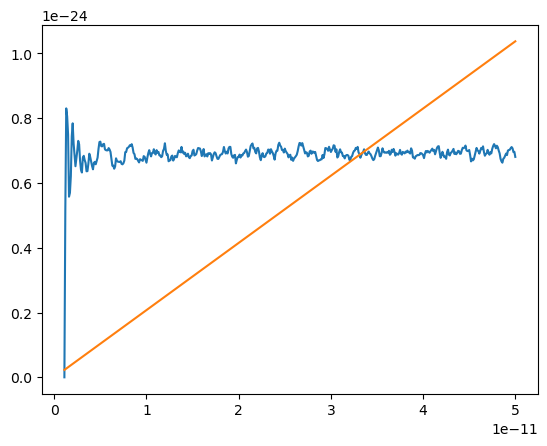

In [99]:
fitfunc = lambda t, a: a*t 
res = scipy.optimize.curve_fit(fitfunc, t[11:], msd[:, 1])
a= res[0]
plt.plot(t[11:], msd[:, 1])
plt.plot(t[11:], fitfunc(t[11:], a))
print("D_2 = %.3e m**2/s" %(a/2))

D_3 = 1.043e-14 m**2/s


/tmp/ipykernel_2051448/3891197636.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("D_3 = %.3e m**2/s" %(a/2))


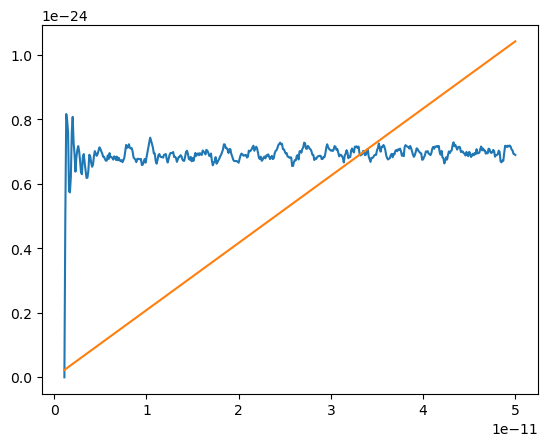

In [100]:
fitfunc = lambda t, a: a*t 
res = scipy.optimize.curve_fit(fitfunc, t[11:], msd[:, 2])
a= res[0]
plt.plot(t[11:], msd[:, 2])
plt.plot(t[11:], fitfunc(t[11:], a))
print("D_3 = %.3e m**2/s" %(a/2))